# [AMPLab] report: essentia task 2 (genre classification)
Notebook created by Philip Tovstogan

## Download data
First we need to download audio data. We use python libraries to retrieve the zip file and extract it to `data` directory in our root. Because the file is reasonably large, we skip this step if the `data` directory already exists

In [11]:
import shutil
import os

from urllib.request import urlretrieve
from zipfile import ZipFile

# Download data
dataset_url = 'http://essentia.upf.edu/documentation/tmp/Essentia_genre_task.zip'
directory = 'data'
filename = 'data.zip'
root_dir = os.path.join(directory, 'genre')

if not os.path.exists(directory):  # we porbably already run this cell
    try:
        os.remove(filename) # remove old zip file if exists
    except FileNotFoundError:
        pass
    urlretrieve(dataset_url, filename)  # download
    
    zip_file = ZipFile(filename, 'r')
    zip_file.extractall(directory)  # extract
    zip_file.close()
    
    os.remove(filename)

## Extract audio features
First we initialize MusicExtractor algorithm, because it will be reused for each file. The only statistics we are interested in is *mean* and *stdev*. Then we go through all the audio files and calculate descriptors and store them as JSON files in the `features` directory that has same structure as `data/genres` in the root. 

Because the process is slow, in case if something went wrong and it was interrupted, we don't overwrite the JSON files - if it exists we assume that the features have already been extracted and it is skipped (indicated by `~` instead of `.` in progress bar).

In [7]:
# Essentia init
import essentia.standard as es
stats = ['mean', 'stdev']
music_extractor = es.MusicExtractor(lowlevelStats=stats, rhythmStats=stats, tonalStats=stats)

In [75]:
# Extract audio features and write them to files
features_dir = 'features'
    
for genre_dir in os.listdir(root_dir):
    print('Analyzing {}: '.format(genre_dir), end='', flush=True)
    genre_path = os.path.join(root_dir, genre_dir)
    features_genre_dir = os.path.join(features_dir, genre_dir)
    os.makedirs(features_genre_dir, exist_ok=True)
    
    for audio_file in os.listdir(genre_path):
        audio_path = os.path.join(genre_path, audio_file)
        json_file = audio_file.replace('.mp3', '.json')
        json_path = os.path.join(features_genre_dir, json_file)

        if not os.path.exists(json_path):
            features, _ = music_extractor(audio_path)
            es.YamlOutput(format='json', filename=json_path)(features)
            print('.', end='', flush=True)
        else:
            print('~', end='', flush=True)
    
    print()

Analyzing jaz: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Analyzing cla: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Analyzing dan: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Analyzing spe: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Analyzing hip: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Analyzing rhy: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Analyzing roc: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Analyzing pop: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Process data

In [76]:
import numpy as np

# Read JSON files and transform them into feature vectors
def pool_to_vector(pool):
    vector = []
    for name in pool.descriptorNames():
        value = pool[name]
        if type(value) is float:  # TODO: maybe accomodate np.ndarrays
            vector.append(value)
    return np.array(vector)

x = []
y = []
y_labels = []

for genre_dir in os.listdir(features_dir):
    y_labels.append(genre_dir)
    genre_path = os.path.join(features_dir, genre_dir)
    
    for feature_file in os.listdir(genre_path):
        feature_path = os.path.join(genre_path, feature_file)
        
        try:
            pool = es.YamlInput(filename=feature_path, format='json')()
        except RuntimeError as e:
            pass
        x.append(pool_to_vector(pool))
        y.append(len(y_labels) - 1)  # genre index

x_raw = np.array(x)
y = np.array(y)

In [77]:
import sklearn as sk
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit as Split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# SVM 
test_size = 0.2

# Pre-process data
x = scale(x_raw)

# Make a balanced split
split = Split(n_splits=1, test_size=test_size, random_state=0)
split.get_n_splits(x, y)

for idx_train, idx_test in split.split(x, y):
    x_train = x[idx_train]
    y_train = y[idx_train]

    x_test = x[idx_test]
    y_test = y[idx_test]

    clf = SVC()
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: {}'.format(accuracy))

Accuracy: 0.8409090909090909


Text(0.5,0,'Predicted genre')

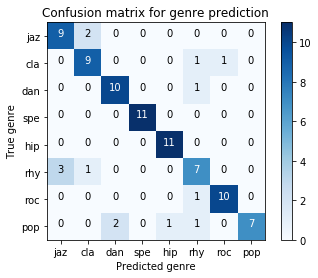

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

matrix = sk.metrics.confusion_matrix(y_test, y_pred)

# Plot
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for genre prediction')
plt.colorbar()
tick_marks = np.arange(len(y_labels))
plt.xticks(tick_marks, y_labels)
plt.yticks(tick_marks, y_labels)

thresh = matrix.max() / 2
for i in range(len(y_labels)):
    for j in range(len(y_labels)):
        plt.text(j, i, matrix[i, j], horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

plt.ylabel('True genre')
plt.xlabel('Predicted genre')